<IPython.core.display.Javascript object>


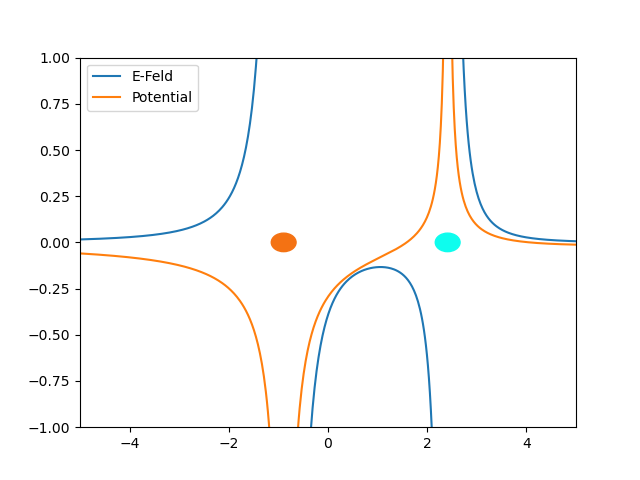

BoundedIntText(value=1, description='Anzahl Ladungen', max=10, min=1)

FloatSlider(value=0.1, description='Ladungsbetrag', max=1.0, min=-1.0)

11

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import ipywidgets as widgets

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-5, 5)
ax.set_ylim(-1, 1)

#create initial charges
radius = 0.5
aspect = (ax.get_ylim()[1] - ax.get_ylim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0])
oval_height = radius * aspect
min_r2 = 0.0005*0.0005
charges = [{'object': mpatches.Ellipse((0.0, 0.0), radius, oval_height, color=list(np.random.ranf(size=3))), 'charge': 0.1}]
edited_charge = 0
dragging = False

#draw all charges
for i in charges:
    ax.add_patch(i['object'])

#generate field
def field(x, charges):
    Ex = 0.0
    
    for i, charge in enumerate(charges):
        rx = charge['object'].get_center()[0] - x
        r2 = rx*rx
        r = np.sqrt(r2)
        
        nx = -rx / r
        
        Ex += charge['charge'] / r2 * nx * (r2>min_r2)
        
        #print(Ex)
        
    return Ex

def mask_Ex(Ex):
    #mask the Ex array to prevent the nonsensical connection line at r=0 from showing
    mEx = np.ma.array(Ex)
    for i in range(0, len(Ex)-1):
        if Ex[i]*Ex[i+1] < 0:
            mEx[i] = np.ma.masked
    
    return mEx

def potential(x, charges):
    phix = 0.0
    
    for i, charge in enumerate(charges):
        rx = charge['object'].get_center()[0] - x
        r2 = rx*rx
        r = np.sqrt(r2)
        
        phix += charge['charge'] / r * (r2>min_r2)
                
    return phix

x = np.linspace(-5,5,500)
Ex = mask_Ex(field(x, charges))
phix = potential(x, charges)
field_plot, = ax.plot(x, Ex, label='E-Feld')
pot_plot, = ax.plot(x, phix, label='Potential')
ax.legend()

#create widgets
def onchangenumber(change):
    if change['name'] == 'value':
        if change['old'] < change['new']:
            charges.append({'object': mpatches.Ellipse((np.random.ranf()*10.0-5.0, 0.0), radius, oval_height, color=list(np.random.ranf(size=3))), 'charge': 0.1})
            ax.add_patch(charges[-1]['object'])
        
        elif change['old'] > change['new']:
            charge = charges.pop()
            charge['object'].remove()
        
        edited_charge = len(charges)
        Ex = mask_Ex(field(x, charges))
        field_plot.set_ydata(Ex)
        phix = potential(x, charges)
        pot_plot.set_ydata(phix)
        fig.canvas.draw()
        
num_charges = widgets.BoundedIntText(value=1, min=1, max=10, step=1, description='Anzahl Ladungen')
num_charges.observe(onchangenumber)
display(num_charges)

def onchangecharge(change):
    if change['name'] == 'value':
        charges[edited_charge]['charge'] = change['new']
        Ex = mask_Ex(field(x, charges))
        field_plot.set_ydata(Ex)
        phix = potential(x, charges)
        pot_plot.set_ydata(phix)
        fig.canvas.draw()

charge_value = widgets.FloatSlider(value=0.1, min=-1, max=1, description='Ladungsbetrag')
charge_value.observe(onchangecharge)
display(charge_value)

def onclick(event):
    global edited_charge
    global dragging
    
    #filter outside events
    if event.inaxes != ax or dragging:
        return
            
    #check if a charge is hit
    hit = -1
    for i, charge in enumerate(charges):
        if charge['object'].contains_point((event.x, event.y)):
            hit = i            
    if hit == -1:
        return
    
    edited_charge = hit
    dragging = True

    #todo: connect property update
    charge_value.value = charges[edited_charge]['charge']

def onrelease(event):
    global edited_charge
    global dragging
    
    dragging = False
    
def ondrag(event):
    global edited_charge
    global dragging
    global field, charges
    
    if dragging:        
        charges[edited_charge]['object'].set_center((event.xdata, 0))
        
        Ex = mask_Ex(field(x, charges))
        field_plot.set_ydata(Ex)
        phix = potential(x, charges)
        pot_plot.set_ydata(phix)
        fig.canvas.draw()

#connect the callbacks
fig.canvas.mpl_connect('button_press_event', onclick)
fig.canvas.mpl_connect('button_release_event', onrelease)
fig.canvas.mpl_connect('motion_notify_event', ondrag)
